import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 784, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

import torch

class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        grad_x = grad_output.clone()
        grad_x[x < 0] = 0
        return grad_x


device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 784, 100, 10

# Create random Tensors to hold input and output
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Create random Tensors for weights.
w1 = torch.randn(D_in, H, device=device, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
  # Forward pass: compute predicted y using operations on Tensors; we call our
  # custom ReLU implementation using the MyReLU.apply function
    y_pred = MyReLU.apply(x.mm(w1)).mm(w2)
 
  # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
  #print(t, loss.item())

  # Use autograd to compute the backward pass.
    loss.backward()

    with torch.no_grad():
   # Update weights using gradient descent
      w1 -= learning_rate * w1.grad
      w2 -= learning_rate * w2.grad
   
      w1.grad.zero_()
      w2.grad.zero_()
 # Manually zero the gradients after running the backward pass

In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchbearer import Trial
import os

In [3]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

In [4]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [5]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

In [6]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [7]:
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

In [8]:
# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

In [9]:
class Fullconnect(nn.Module):
    """
    在每层的输出部分添加了激活函数
    """
    def __init__(self):
        super(Fullconnect, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(784, 100), nn.ReLU(True), nn.Dropout(p=0.5))
        self.layer2 = nn.Sequential(nn.Linear(100, 100), nn.ReLU(True), nn.Dropout(p=0.5))
        self.layer3 = nn.Sequential(nn.Linear(100, 10), nn.ReLU(True), nn.Dropout(p=0.5))
        self.softmax = torch.nn.Softmax(dim=1)
        """
        这里的Sequential()函数的功能是将网络的层组合到一起。
        """
 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x



In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

import torch
import torchvision
import torchvision.transforms as transforms
 
#  **由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**
    #  首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )
    #  把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
 
    # 定义了我们的训练集，名字就叫trainset，至于后面这一堆，其实就是一个类：
    # torchvision.datasets.CIFAR10( )也是封装好了的，就在我前面提到的torchvision.datasets
    # 模块中,不必深究，如果想深究就看我这段代码后面贴的图1，其实就是在下载数据
    #（不翻墙可能会慢一点吧）然后进行变换，可以看到transform就是我们上面定义的transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    # trainloader其实是一个比较重要的东西，我们后面就是通过trainloader把数据传入网
    # 络，当然这里的trainloader其实是个变量名，可以随便取，重点是他是由后面的
    # torch.utils.data.DataLoader()定义的，这个东西来源于torch.utils.data模块，
    #  网页链接http://pytorch.org/docs/0.3.0/data.html，这个类可见我后面图2
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
    # 对于测试集的操作和训练集一样，我就不赘述了
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)
    # 类别信息也是需要我们给定的
classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [11]:
import torch
from torch.optim import Optimizer


class MySGD(Optimizer):

    def __init__(self, params, lr=0, weight_decay=0, alpha=0, kappa_t=0):
        if lr and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if alpha <0.0:
            raise ValueError("Invalid alpha value: {}".format(alpha))
        if kappa_t <0.0:
            raise ValueError("Invalid alpha value: {}".format(kappa_t))

        defaults = dict(lr=lr, weight_decay=weight_decay, alpha=alpha, kappa_t=kappa_t)

        super(MySGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(MySGD, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            weight_decay = group['weight_decay']
            lr = group['lr']
            alpha = group['alpha']
            kappa_t = group['kappa_t']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)    #存参数
                    d_p_list.append(p.grad)        #存梯度

                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])
            #SGD COMPUTE
            for i, param in enumerate(params_with_grad):
                d_p = d_p_list[i]
                #正则化
                if weight_decay != 0:
                    d_p = d_p.add(param, alpha=weight_decay)

                buf = momentum_buffer_list[i]

                if buf is None:
                    buf = torch.clone(d_p).detach()
                    momentum_buffer_list[i] = buf
                else:
                    delta = lr/alpha/kappa_t
                    #delta = lr/alpha
                    buf.mul_(1 - alpha).add_(d_p, alpha=-(delta)).add_(param.data, alpha=alpha)

                param.mul_(1/(1+alpha)).add_(d_p, alpha=-(lr/(1+alpha))).add_(buf, alpha=(alpha / (1 + alpha)))

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss

In [12]:
import torchbearer

# define the loss function and the optimiser
model = Fullconnect()
model2 = Fullconnect()
model3 = Fullconnect()
model4 = Fullconnect()

loss_function = nn.CrossEntropyLoss()
loss_function2= nn.CrossEntropyLoss()
loss_function3= nn.CrossEntropyLoss()
loss_function4 = nn.CrossEntropyLoss()

optimiser = MySGD(model.parameters(), lr=0.01, alpha=0.05, kappa_t=3)
optimiser2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
optimiser3 = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimiser4 = optim.Adam(model4.parameters(), lr=0.001)

# Construct a trial object with the model, optimiser and loss.
# Also specify metrics we wish to compute.
trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial2 = torchbearer.Trial(model2, optimiser2, loss_function2, metrics=['loss', 'accuracy']).to(device)
trial3 = torchbearer.Trial(model3, optimiser3, loss_function3, metrics=['loss', 'accuracy']).to(device)
trial4 = torchbearer.Trial(model4, optimiser4, loss_function4, metrics=['loss', 'accuracy']).to(device)

# Provide the data to the trial
trial.with_generators(trainloader, val_generator=testloader)
trial2.with_generators(trainloader, val_generator=testloader)
trial3.with_generators(trainloader, val_generator=testloader)
trial4.with_generators(trainloader, val_generator=testloader)

# Run 10 epochs of training
result = trial.run(epochs=150, verbose=1)
result2 = trial2.run(epochs=150, verbose=1)
result3 = trial3.run(epochs=150, verbose=1)
result4 = trial4.run(epochs=150, verbose=1)
print(result,result2)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'running_loss': 2.3024566173553467, 'running_acc': 0.10906250029802322, 'loss': 2.302534580230713, 'acc': 0.10273333638906479, 'val_loss': 2.3024303913116455, 'val_acc': 0.1031000018119812, 'train_steps': 469, 'validation_steps': 79}, {'running_loss': 2.302222967147827, 'running_acc': 0.1145312488079071, 'loss': 2.302320718765259, 'acc': 0.11630000174045563, 'val_loss': 2.302241563796997, 'val_acc': 0.13289999961853027, 'train_steps': 469, 'validation_steps': 79}, {'running_loss': 2.3020741939544678, 'running_acc': 0.10796874761581421, 'loss': 2.3021130561828613, 'acc': 0.11018333584070206, 'val_loss': 2.301950216293335, 'val_acc': 0.1137000024318695, 'train_steps': 469, 'validation_steps': 79}, {'running_loss': 2.301439046859741, 'running_acc': 0.11140625178813934, 'loss': 2.3017539978027344, 'acc': 0.10936667025089264, 'val_loss': 2.301445722579956, 'val_acc': 0.11410000175237656, 'train_steps': 469, 'validation_steps': 79}, {'running_loss': 2.2996017932891846, 'running_acc': 0.124

In [14]:
print (result4)

[{'running_loss': 1.9677549600601196, 'running_acc': 0.4664062559604645, 'loss': 2.0409228801727295, 'acc': 0.40058332681655884, 'val_loss': 1.6131455898284912, 'val_acc': 0.9065999984741211, 'train_steps': 469, 'validation_steps': 79}, {'running_loss': 1.950038194656372, 'running_acc': 0.47703126072883606, 'loss': 1.9540481567382812, 'acc': 0.4767666757106781, 'val_loss': 1.5716490745544434, 'val_acc': 0.9228000044822693, 'train_steps': 469, 'validation_steps': 79}, {'running_loss': 1.9374184608459473, 'running_acc': 0.49546873569488525, 'loss': 1.9411720037460327, 'acc': 0.48846668004989624, 'val_loss': 1.5559161901474, 'val_acc': 0.9294999837875366, 'train_steps': 469, 'validation_steps': 79}, {'running_loss': 1.9339251518249512, 'running_acc': 0.49781250953674316, 'loss': 1.933565378189087, 'acc': 0.4970499873161316, 'val_loss': 1.551505208015442, 'val_acc': 0.9312000274658203, 'train_steps': 469, 'validation_steps': 79}, {'running_loss': 1.9282077550888062, 'running_acc': 0.506250

(Text(0.5, 1.0, 'Loss'), <matplotlib.legend.Legend at 0x1c0bb04a6a0>, None)

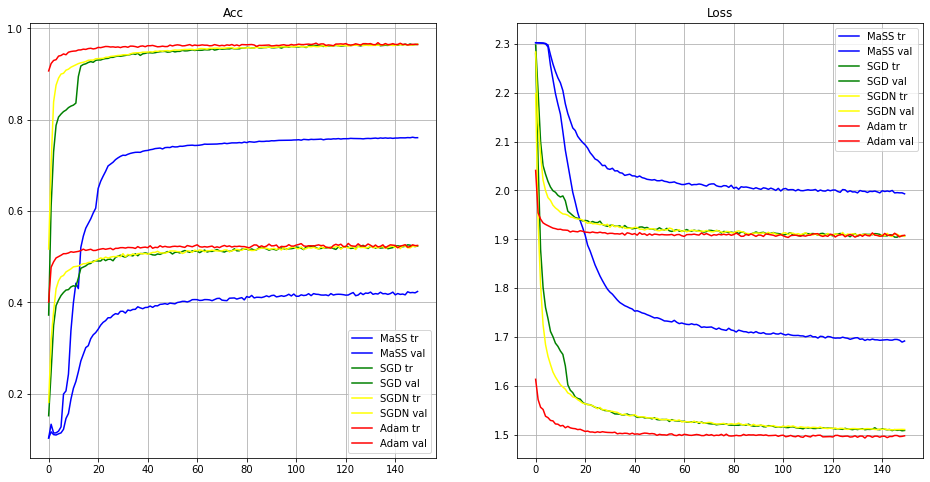

In [18]:
import matplotlib.pyplot as plt
train_acc = []
val_acc = []
train_acc_SGD = []
val_acc_SGD = []
train_acc_SGDN = []
val_acc_SGDN = []
train_acc_Adam = []
val_acc_Adam = []



train_loss = []
val_loss = []
train_loss_SGD = []
val_loss_SGD = []
train_loss_SGDN = []
val_loss_SGDN = []
train_loss_Adam = []
val_loss_Adam = []

for i in range(len(result)):
    train_acc.append(result[i]['acc'])
    val_acc.append(result[i]['val_acc'])
    
    train_acc_SGD.append(result2[i]['acc'])
    val_acc_SGD.append(result2[i]['val_acc'])
    
    train_acc_SGDN.append(result3[i]['acc'])
    val_acc_SGDN.append(result3[i]['val_acc'])
    
    train_acc_Adam.append(result4[i]['acc'])
    val_acc_Adam.append(result4[i]['val_acc'])
    
    train_loss.append(result[i]['loss'])
    val_loss.append(result[i]['val_loss'])
    
    train_loss_SGD.append(result2[i]['loss'])
    val_loss_SGD.append(result2[i]['val_loss'])
    
    train_loss_SGDN.append(result3[i]['loss'])
    val_loss_SGDN.append(result3[i]['val_loss'])
    
    train_loss_Adam.append(result4[i]['loss'])
    val_loss_Adam.append(result4[i]['val_loss'])
    


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].plot(range(len(result)), train_acc, c='blue',label='MaSS tr')
ax[0].plot(range(len(result)), val_acc, c='blue',label='MaSS val')

ax[0].plot(range(len(result2)), train_acc_SGD, c='green',label='SGD tr')
ax[0].plot(range(len(result2)), val_acc_SGD,c='green',label='SGD val')

ax[0].plot(range(len(result3)), train_acc_SGDN, c='yellow',label='SGDN tr')
ax[0].plot(range(len(result3)), val_acc_SGDN ,c='yellow',label='SGDN val')

ax[0].plot(range(len(result4)), train_acc_Adam, c='red',label='Adam tr')
ax[0].plot(range(len(result4)), val_acc_Adam, c='red',label='Adam val')

ax[0].set_title('Acc'),ax[0].legend(),ax[0].grid(True)


ax[1].plot(range(len(result)), train_loss, c='blue',label='MaSS tr')
ax[1].plot(range(len(result)), val_loss, c='blue',label='MaSS val')

ax[1].plot(range(len(result2)), train_loss_SGD, c='green',label='SGD tr')
ax[1].plot(range(len(result2)), val_loss_SGD,c='green',label='SGD val')

ax[1].plot(range(len(result3)), train_loss_SGDN, c='yellow',label='SGDN tr')
ax[1].plot(range(len(result3)), val_loss_SGDN ,c='yellow',label='SGDN val')

ax[1].plot(range(len(result4)), train_loss_Adam, c='red',label='Adam tr')
ax[1].plot(range(len(result4)), val_loss_Adam, c='red',label='Adam val')
ax[1].set_title('Loss'),ax[1].legend(),ax[1].grid(True)